# Spatial architecture - niche composition

Spatial composition analysis identifies multi-cellular niches that composed by cell types with specific proportion.

You can download `adata_combine_7celltype.h5ad` from https://zenodo.org/records/14588408.

MIBI-TOF TNBC samples were used as in **tutorial: Cell type proximity**

## Read

In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import SOAPy_st as sp
import numpy as np

To simplify the analyzed data, the cell types were combined, and **DK cells**, **NK cells**, **Neutrophil cells**, **Treg cells**, and **other immune cell** categories were collectively referred to as **other**.

In [2]:
adata_com = sc.read('/csb2/project/SpatialPackage_whq/Tutorial/data/adata_combine_7celltype.h5ad')

## Constructing spatial network

the cell-cell network was built using 100 pixels as the radius to capture the composition pattern of more surrounding cells

In [3]:
sp.pp.make_network(adata_com, sample_key='sample', method='radius', cutoff=100, scale=1.0, cluster_key='cluster')

AnnData object with n_obs × n_vars = 211649 × 44
    obs: 'sample', 'leiden', 'cluster'
    var: 'highly_variable'
    uns: 'cluster_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'var_for_clustering', 'SOAPy'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## C-niche cluster

Each cell was represented by the proportion of cell type of its surrounding cells (niche). 211649 cells from 41 TNBC samples were clustered into 30 C-niche clusters.

In [4]:
sp.tl.get_c_niche(adata=adata_com, k_max=30, celltype_key='cluster', sample_key='sample')

AnnData object with n_obs × n_vars = 211649 × 44
    obs: 'sample', 'leiden', 'cluster', 'C_niche'
    var: 'highly_variable'
    uns: 'cluster_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'var_for_clustering', 'SOAPy'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Show the cellular composition of each C-niche.

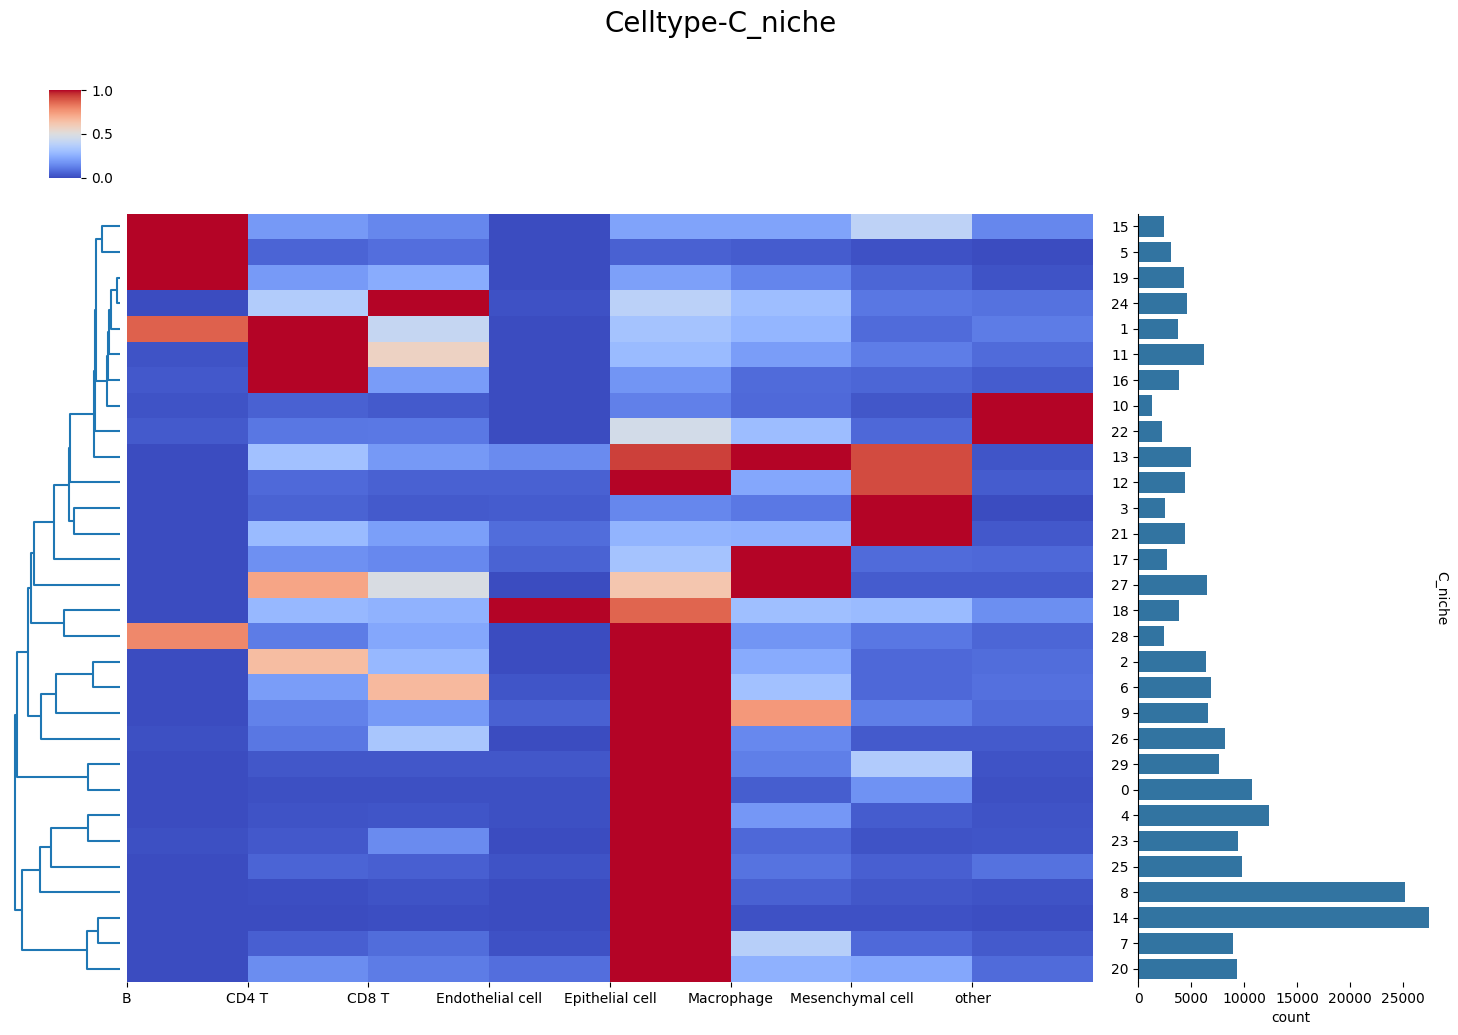

In [5]:
fig = sp.pl.show_celltype_niche_heatmap(adata=adata_com, cmap = 'coolwarm', figsize=(20, 16))

Show the cell type composition of each sample.

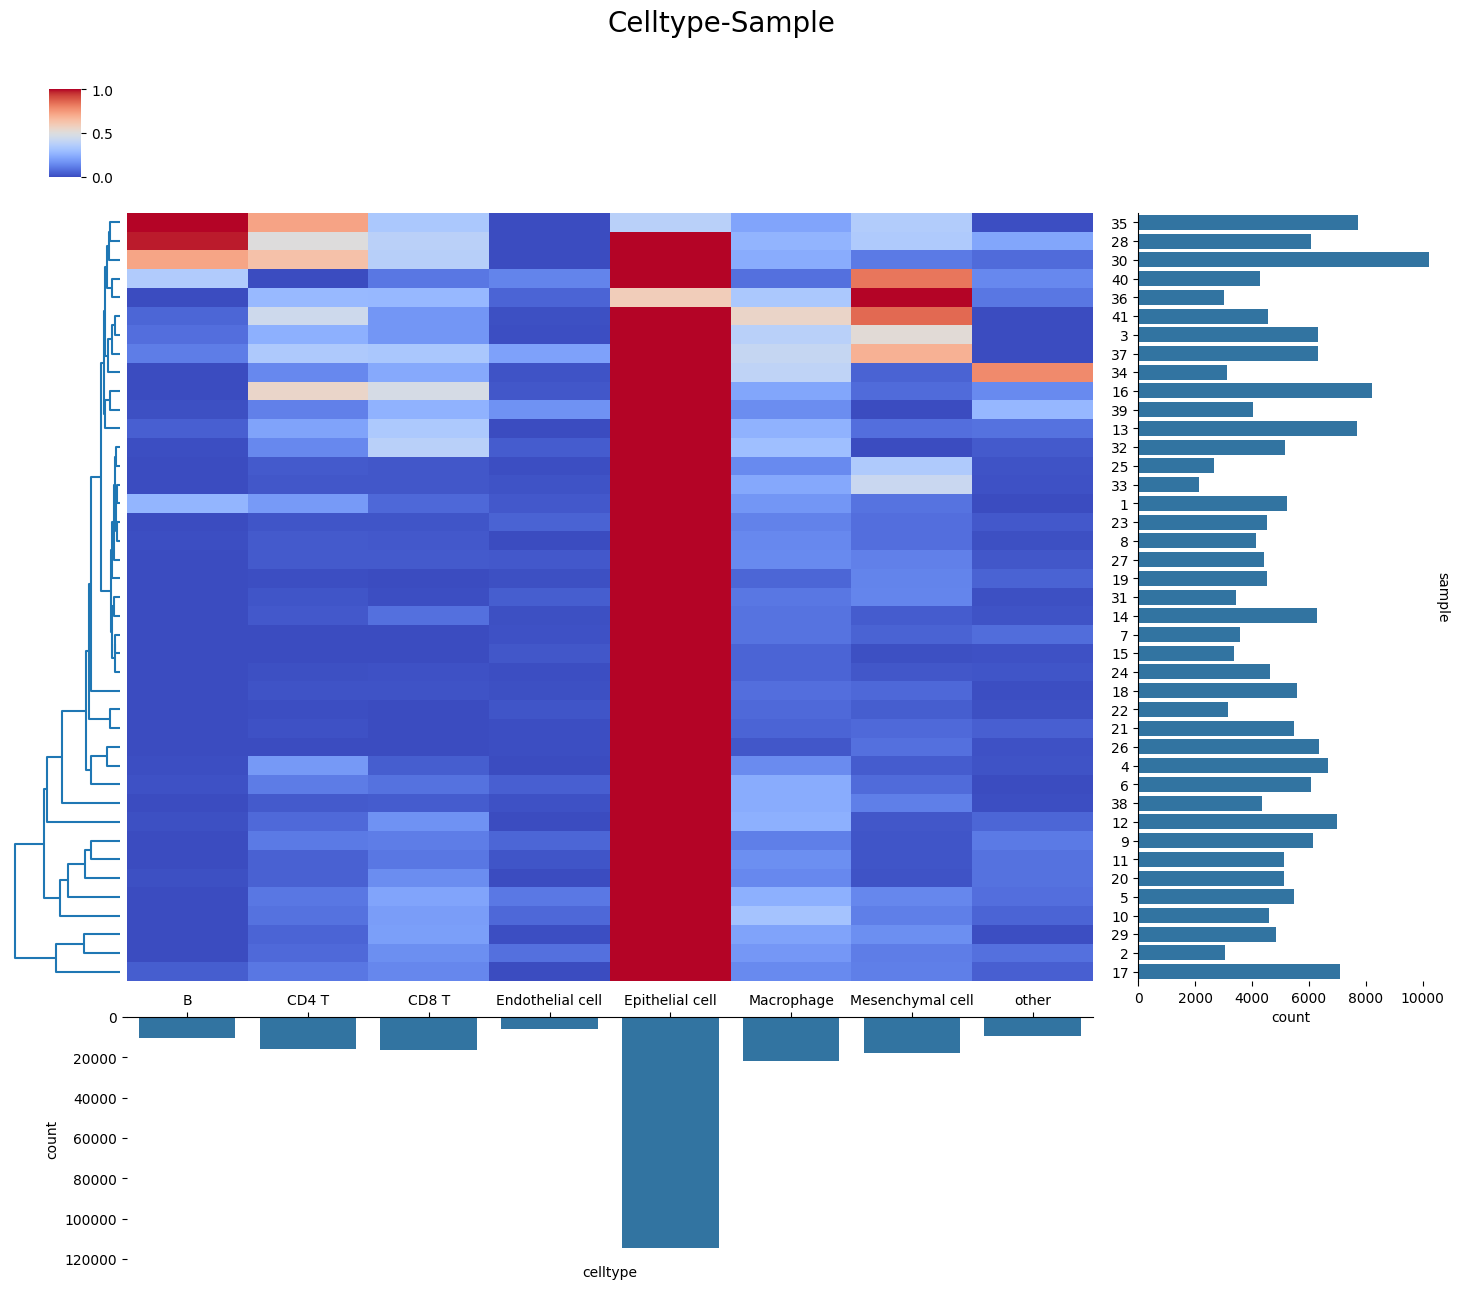

In [6]:
fig = sp.pl.show_celltype_sample_heatmap(adata=adata_com, cmap = 'coolwarm', figsize=(20, 16))

Show the C-niche composition of each sample.

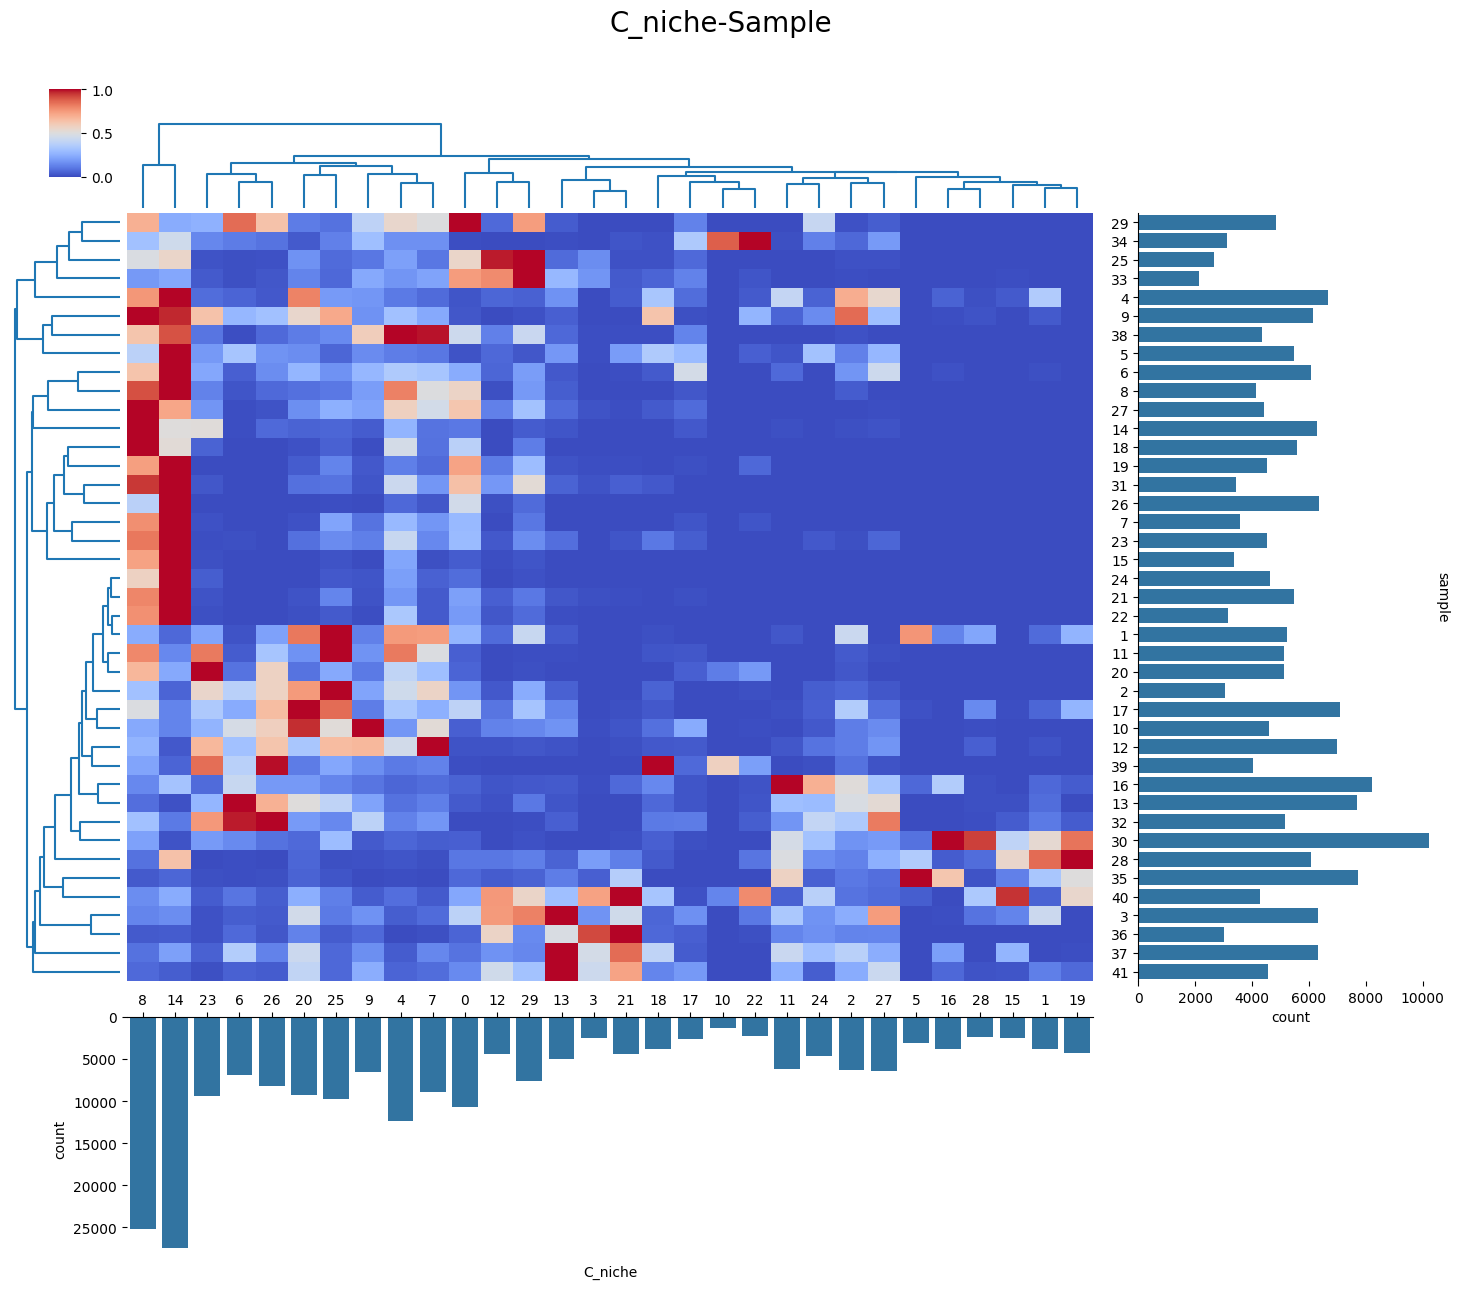

In [7]:
fig = sp.pl.show_niche_sample_heatmap(adata=adata_com, cmap = 'coolwarm', figsize=(20, 16))

Show the composition of the microenvironment belonging to C-niche5 cells in sample 1

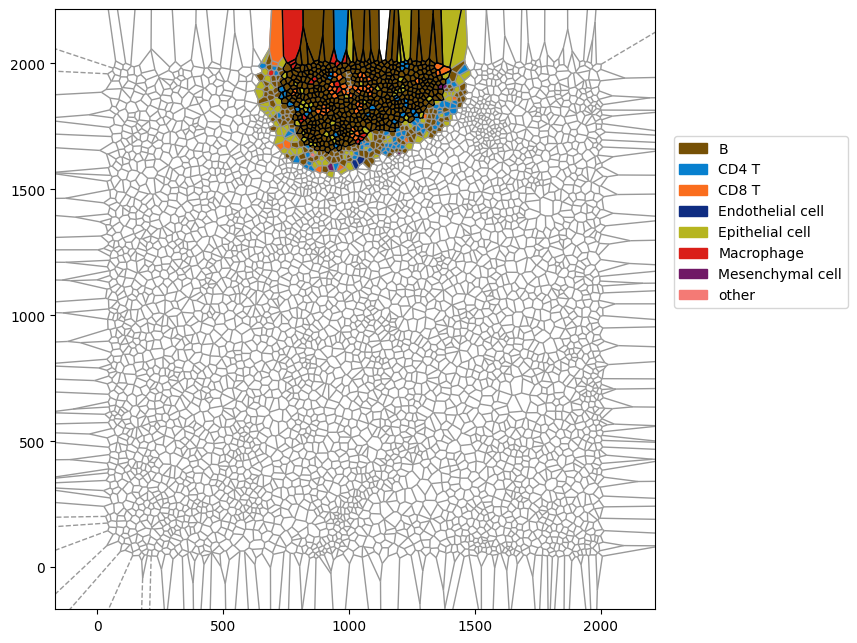

In [8]:
# Fixed color map of each cell type
color_map = {
    'other': '#999999',
    'B': '#765005',
    'CD4 T': '#0780cf',
    'CD8 T': '#fa6d1d',
    'Endothelial cell': '#024b51',
    'Epithelial cell': '#b6b51f',
    'Macrophage': '#da1f18',
    'Mesenchymal cell': '#701866'
}

# Black boundary: cells of C-niche 2, Gray boundary: cells of C-niche 
# Filled areas with colors of cell types: the range of microenvironments labeled as C-niche 2 cells.

fig = sp.pl.show_niche_environment(
    adata=adata_com,
    celltype_key='cluster',
    sample_key='sample',
    sample_id=1,
    color=color_map,
    niche_key='C_niche',
    niche=5
)

## Tensor decomposition of niche

In order to investigate the combinational effects of cell types and niches on patient heterogeneity, the “Niche-CellType (without epithelial)-Sample” tensor (size: 30\*7\*41) was factorized to four factors

To highlight the more diverse microenvironment composition, epithelial cells were removed when constructing the tensor.

In [9]:
niche_tensor = sp.tl.TensorDecomposition()
adata_copy = adata_com[adata_com.obs['cluster'] != 'Epithelial cell', :].copy()
niche_tensor.tensor_with_obs(adata_copy, obs_factor=['sample', 'cluster', 'C_niche'])

Each sample is internally normalized followed by non-negative CP decomposition

In [10]:
niche_tensor.normalization(factor_name='sample')
weights, factors, nre = niche_tensor.CP_decomposition(rank=4, non_negative=True)

The sample factor matrix is clustered, and the samples with the similar microenvironment are clustered into one class.

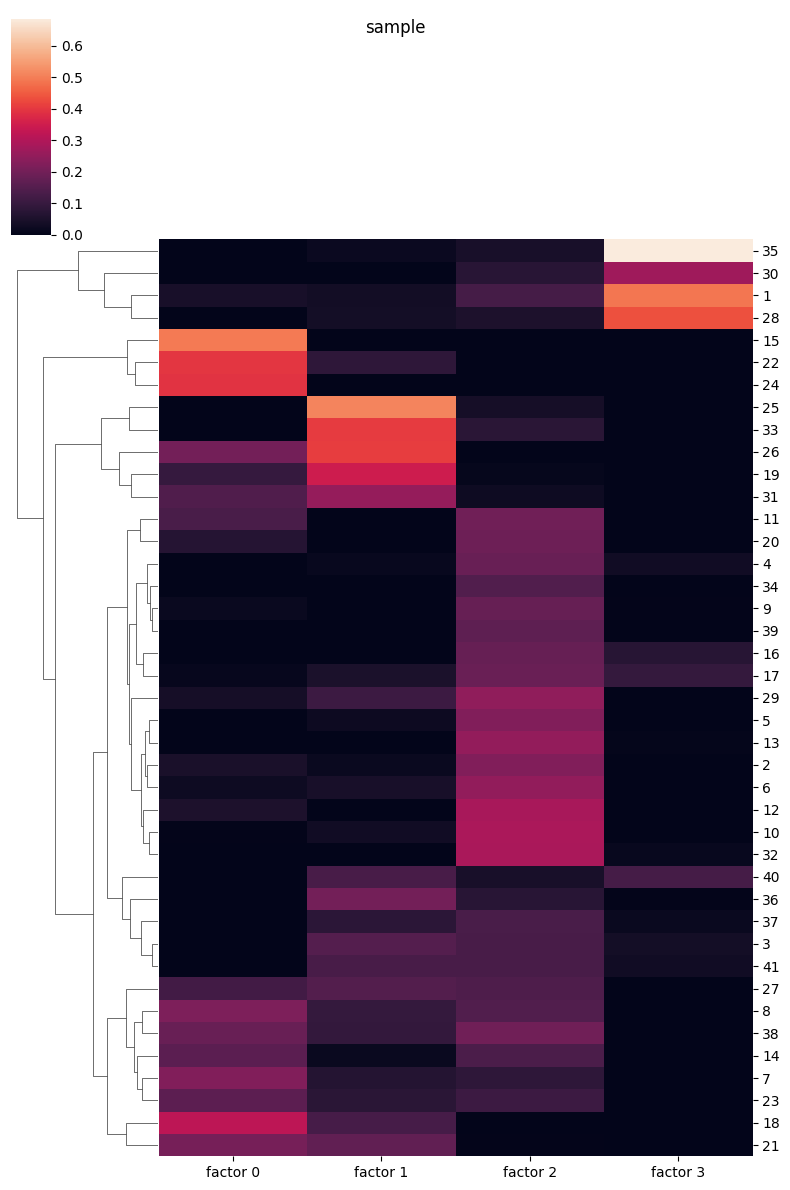

In [11]:
sp.pl.show_factor_matrix_in_CP_tensor(tensor=niche_tensor, factor_name='sample', figsize=(8, 12))

Through the orthographic observation of the samples, the samples enriched in factor 3 have a large number of enriched regions of B cells, which may correspond to tertiary lymph node structures.

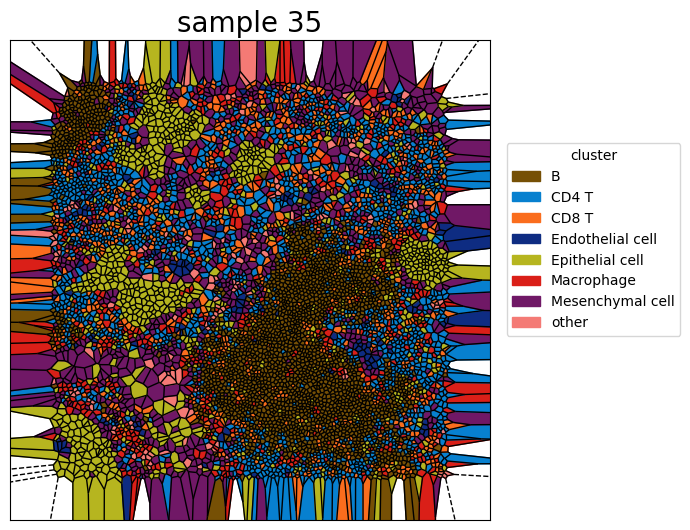

In [12]:
sp.pl.show_voronoi(adata_com, sample_id = 35, cluster_key='cluster', title = 'sample 35')

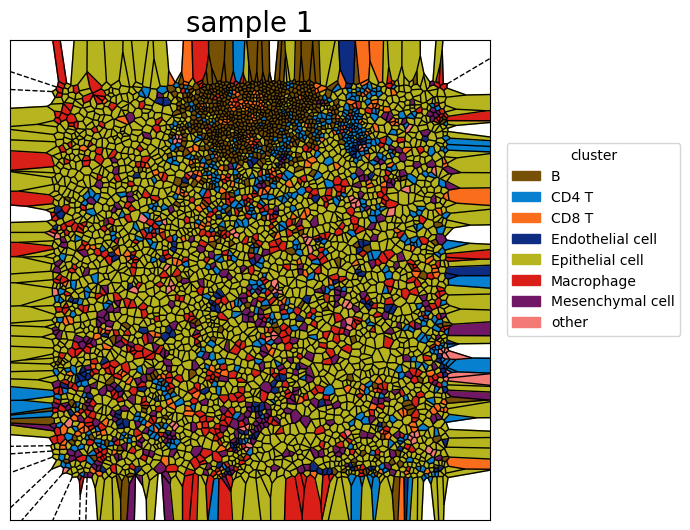

In [13]:
sp.pl.show_voronoi(adata_com, sample_id = 1, cluster_key='cluster', title = 'sample 1')